# Sentiment Analysis on IMDB dataset of movie reviews.
### Machine Learning Project created by-
### 1. Karan Vasudevamurthy
### 2. Suraj Kalyampudi
### 3. Sai Krishna Movva Jaya

##### Link to the dataset - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

### Importing Required Libraries

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Bidirectional, BatchNormalization
)
from sklearn.model_selection import train_test_split


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading the dataset

In [3]:
train_df = pd.read_csv('/content/IMDB Dataset.csv')
print("The Shape of the Dataset: ", train_df.shape)
print(train_df.head())

The Shape of the Dataset:  (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


First, we will load the IMDB Dataset containing movie reviews and their corresponding sentiment labels (positive/negative). We also display the shape of the dataset and the first 5 rows.

## Exploratory Data Analysis




First, we will see the first 10 positive and negative reviews

In [4]:
good_reviews=train_df[train_df['sentiment']=='positive']['review']
bad_reviews=train_df[train_df['sentiment']=='negative']['review']
print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])

First 10 samples of good reviews
 0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
4     Petter Mattei's "Love in the Time of Money" is...
5     Probably my all-time favorite movie, a story o...
6     I sure would like to see a resurrection of a u...
9     If you like original gut wrenching laughter yo...
14    This a fantastic movie of three prisoners who ...
16    Some films just simply should not be remade. T...
18    I remember this film,it was the first film i h...
Name: review, dtype: object
First 10 samples of bad reviews
 3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
12    So im not a big fan of Boll's work but then ag...
13    The

We can see that we have HTML tags, we have puntuations and even stopwords.

Now, let us check what is the distribution of positive and negative reviews in the dataset

Total Counts of both sets sentiment
positive    25000
negative    25000
Name: count, dtype: int64


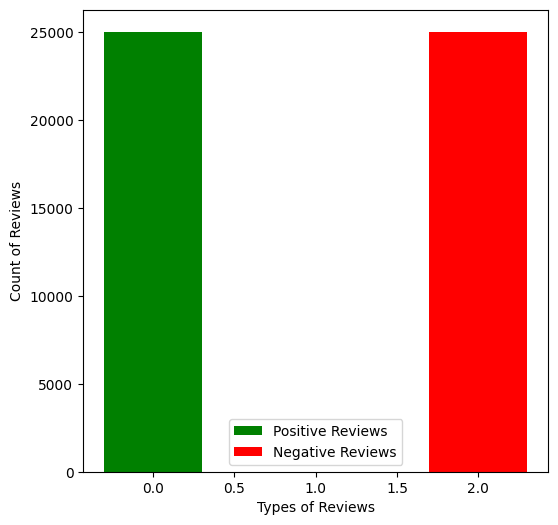

In [5]:
count=train_df['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()

count_good=train_df[train_df['sentiment']=='positive']
count_bad=train_df[train_df['sentiment']=='negative']
plot_counts(len(count_good),len(count_bad))

We can see that both the positive and negative reviews are 25000 each.

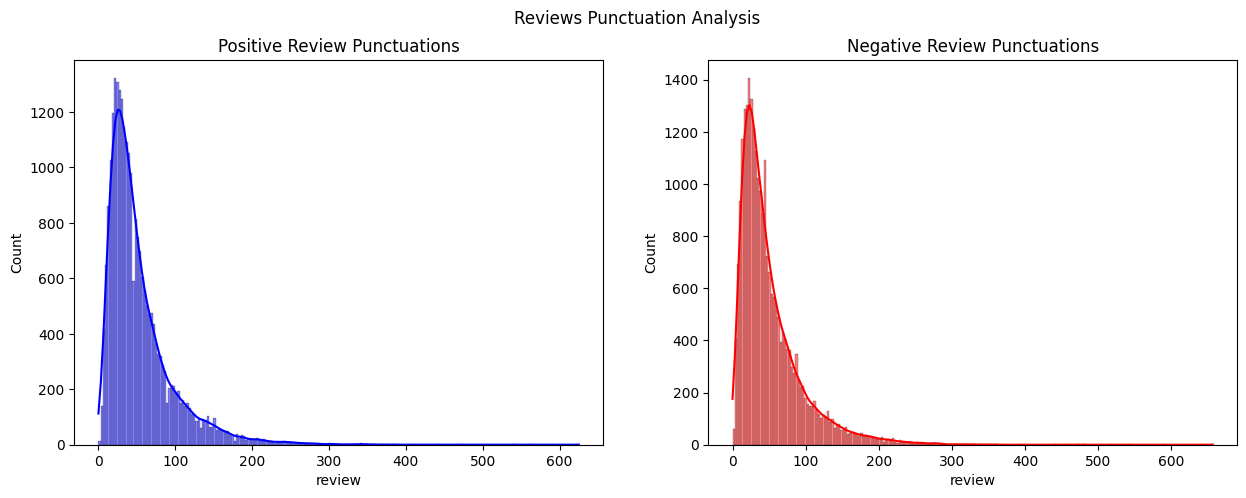

In [6]:
# Count punctuations
count_good_punctuations = count_good['review'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_bad_punctuations = count_bad['review'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
#Plotting
def plot_count(count_ones, count_zeros, title_1, title_2, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Red', kde=True)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

plot_count(
    count_good_punctuations,
    count_bad_punctuations,
    "Positive Review Punctuations",
    "Negative Review Punctuations",
    "Reviews Punctuation Analysis"
)

This block calculates the number of punctuations in both positive and negative reviews. We use Seaborn’s histplot to visualize the frequency distribution, with KDE (Kernel Density Estimation) enabled for a smooth curve over the histogram.

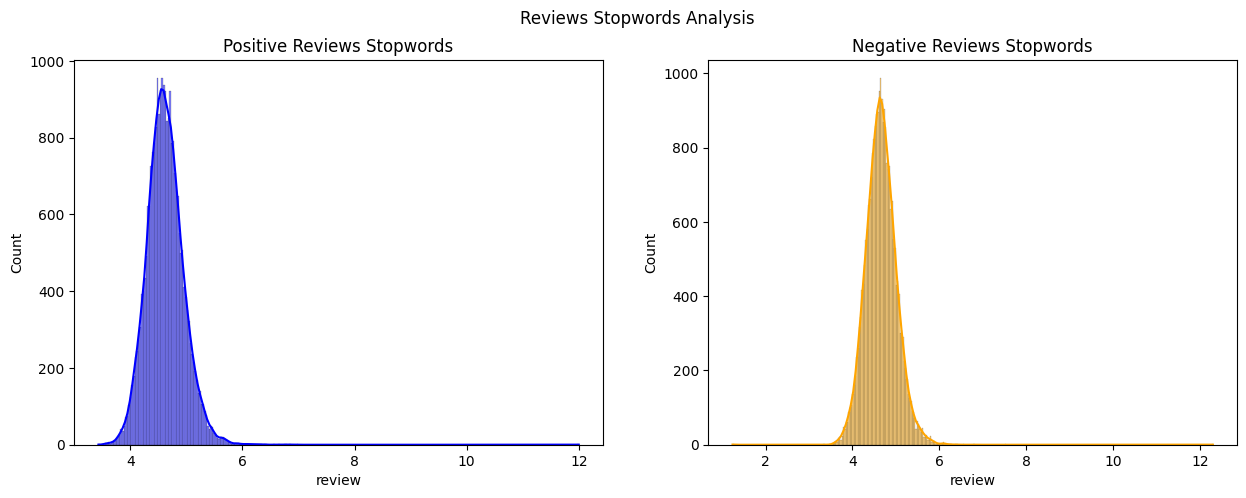

In [7]:
# Get list of English stopwords
stops = set(stopwords.words('english'))

# Calculate mean word length in positive and negative reviews
count_good_stops = count_good['review'].apply(lambda z: np.mean([len(w) for w in str(z).split()]))
count_bad_stops = count_bad['review'].apply(lambda z: np.mean([len(w) for w in str(z).split()]))

# Plot stopwords analysis using Seaborn
def plot_count_1(count_ones, count_zeros, title_1, title_2, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Orange', kde=True)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

plot_count_1(
    count_good_stops,
    count_bad_stops,
    "Positive Reviews Stopwords",
    "Negative Reviews Stopwords",
    "Reviews Stopwords Analysis"
)


This block uses Seaborn’s histplot to visualize the average word length in positive and negative reviews. The usage of stopwords can vary between sentiment types, and visualizing the distributions gives insights into these patterns.

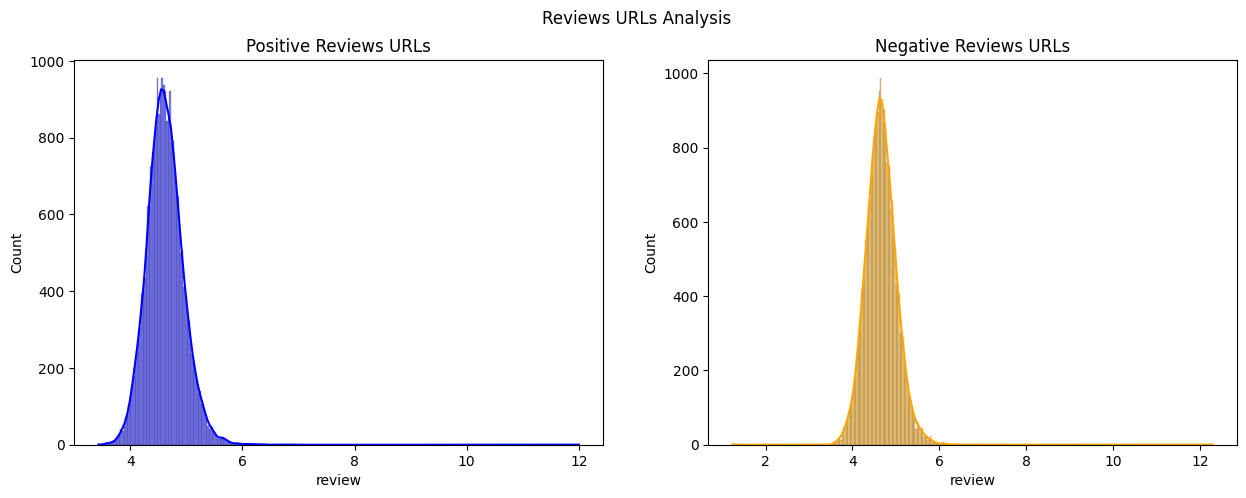

In [8]:
# Count URLs in positive and negative reviews
count_good_urls=count_good['review'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
count_bad_urls=count_bad['review'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

plot_count_1(count_good_stops,count_bad_stops,"Positive Reviews URLs","Negative Reviews URLs","Reviews URLs Analysis")


In this block, we analyze the frequency of URLs in reviews. Using Seaborn’s histplot, we compare the presence of URLs between positive and negative reviews to understand if there's a noticeable difference.

So, what does this mean for us?

The following can be inferred from the data:


*   The dataset is balanced.
*   The dataset contains equal number of semantics for reviews of both polarity.
*   The dataset contains redundant words and html syntaxes.
*   Punctuations/stopwords are present in a equal distribution in the dataset.

So now we need to clean all this data

## Data Cleaning

First, we have to define our data cleaning functions based on what we have learnt from our EDA.

In [9]:

def remove_punctuations(data):
    return re.sub(r'[^\w\s]', '', data)

def remove_html(data):
    return re.sub(r'<.*?>', '', data)

def remove_url(data):
    return re.sub(r"https?://\S+|www\.\S+", '', data)

def remove_emoji(data):
    return re.sub(
        "[" u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"      # symbols & pictographs
        u"\U0001F680-\U0001F6FF"      # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"      # flags (iOS)
        "]+", '', data)

We define multiple functions to clean the text data by removing:
* Punctuations
* HTML tags
* URLs
* Emojis

These preprocessing steps help in cleaning the dataset for better modeling.

Now we want to apply these functions to pre process all our data in the dataframe

In [10]:
# Apply preprocessing functions
train_df['review'] = train_df['review'].apply(lambda x: remove_punctuations(x))
train_df['review'] = train_df['review'].apply(lambda x: remove_html(x))
train_df['review'] = train_df['review'].apply(lambda x: remove_url(x))
train_df['review'] = train_df['review'].apply(lambda x: remove_emoji(x))

# Encode target labels (positive -> 1, negative -> 0)
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

train_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production br br The filmin...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


Additionally, in this step, the target variable (sentiment) is encoded to 1 for positive and 0 for negative reviews.

### Tokenization and Padding

In [11]:
# Tokenization and padding
X = train_df['review'].values
y = train_df['sentiment'].values

# Define tokenizer and fit on texts
tokenizer = Tokenizer(num_words=5000)  # Use the top 5000 words
tokenizer.fit_on_texts(X)

# Convert text to sequences
X = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
max_len = 200  # Trial and Error picked :P
X = pad_sequences(X, maxlen=max_len)


Tokenization converts the text into sequences of numerical values.

Padding ensures all input sequences have the same length (200 in this case).

### Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We split the dataset into 80% training and 20% testing sets to train the LSTM model and evaluate its performance.

## LSTM Definition and Compiling



In [13]:
# LSTM Model
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Key Features of our LSTM:

* An Embedding layer to convert tokens into dense vectors.
* SpatialDropout1D to prevent overfitting.
* LSTM layer with recurrent dropout.
* Dense layer with sigmoid activation for binary classification.
* The model is compiled using the Adam optimizer and binary crossentropy loss.


## TRAINING THE LSTM !!

In [14]:
# Train the model
batch_size = 64
epochs = 3

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 294ms/step - accuracy: 0.7103 - loss: 0.5464 - val_accuracy: 0.8549 - val_loss: 0.3473
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 272ms/step - accuracy: 0.8625 - loss: 0.3320 - val_accuracy: 0.8807 - val_loss: 0.2948
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 274ms/step - accuracy: 0.8766 - loss: 0.3097 - val_accuracy: 0.8269 - val_loss: 0.3833


We train the LSTM model for 3 epochs with a batch size of 64. We also validate the model on the test set after each epoch.

## Model Evaluation

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8290 - loss: 0.3833
Test Accuracy: 82.69%


Let's look at their test accuracies !

#### Plot Training History

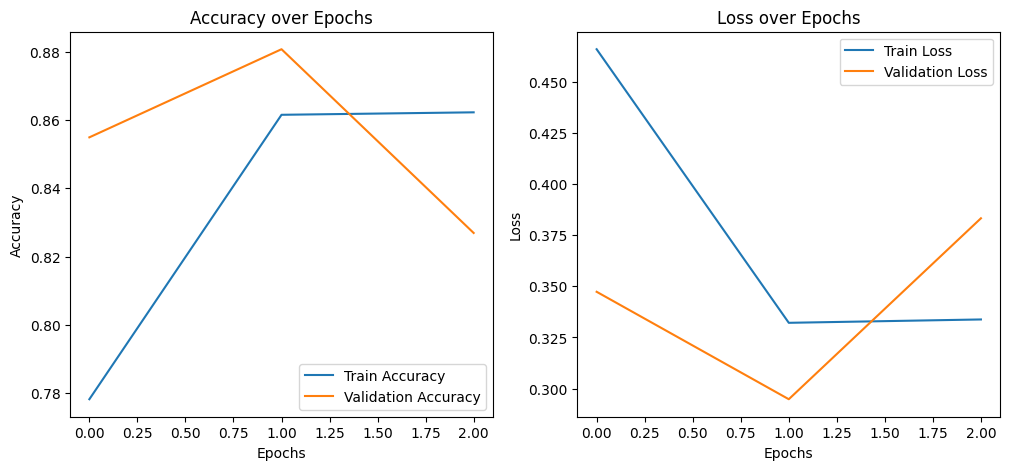

In [16]:
# Plot accuracy and loss over epochs
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

### Let's try it out !

Change whatever you want to change in new_reviews

In [17]:
# Save the model after training
model.save('lstm_sentiment_model.h5')

# Load the model for predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = load_model('lstm_sentiment_model.h5')

# Example reviews to test
new_reviews = [
    "The movie had continuity but I enjoyed it!"
]

# Re-fit the tokenizer on the training data (ensure same parameters)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['review'].values)

# Convert new reviews to sequences
new_sequences = tokenizer.texts_to_sequences(new_reviews)

# Pad the sequences to the same max_len as used in training
max_len = 200
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Predict sentiment
predictions = model.predict(new_padded)

# Display the results
for i, review in enumerate(new_reviews):
    sentiment = 'positive' if predictions[i] >= 0.5 else 'negative'
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Review: The movie had continuity but I enjoyed it!
Predicted Sentiment: positive



## Bi-Directional LSTMs

Now let's get into Bi directional LSTMs.


Directional LSTMs refer to how an LSTM (Long Short-Term Memory) network processes sequences:

Unidirectional LSTM: Processes the sequence in one direction (either from past to future or vice versa). It only considers previous information when making predictions.

Bidirectional LSTM: Processes the sequence in both directions (forward and backward) by using two LSTM layers. This allows the model to capture both past and future context, making it more effective for tasks like sentiment analysis or speech recognition where the whole sequence's context matters.

In [ ]:
# Enhanced Bidirectional LSTM Model
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(BatchNormalization())  # Normalize for stability
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Key highlights about our model -

* Bidirectional layers to capture context from both directions.
* SpatialDropout1D and BatchNormalization for better regularization.
* Dropout layers to prevent overfitting.
* A Dense output layer with sigmoid activation for binary classification.

### Training this Bi-directional Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
# Train the model
batch_size = 64
epochs = 3

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 619s 966ms/step - accuracy: 0.6715 - loss: 0.5803 - val_accuracy: 0.8647 - val_loss: 0.3366
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 607s 943ms/step - accuracy: 0.8566 - loss: 0.3441 - val_accuracy: 0.8752 - val_loss: 0.2967
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - accuracy: 0.8773 - loss: 0.3016 - val_accuracy: 0.8715 - val_loss: 0.2954


Bidirectional LSTM model is trained for 5 epochs with a batch size of 64. EarlyStopping is used to prevent overfitting by halting training when validation loss stops improving.



Early stopping is a technique that halts training when a model’s performance on the validation set stops improving, preventing overfitting and saving time.

### Model Evaluation

Printing the test accuracy

In [25]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 381ms/step - accuracy: 0.8711 - loss: 0.2979
Test Accuracy: 87.15%


### Plotting Accuracy and Loss over Epochs

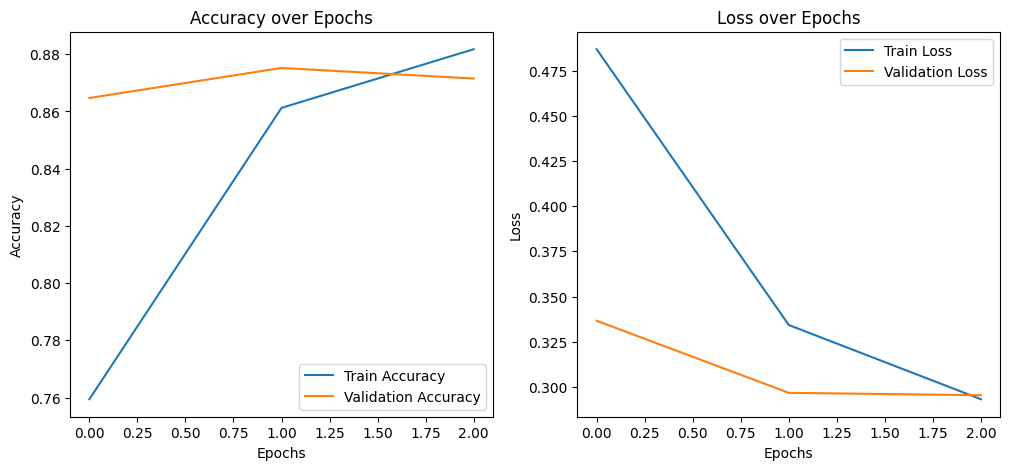

In [26]:
# Plot accuracy and loss over epochs
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)
